# PROYECTO POLISOMNOGRAMA
## CIENCIA DE DATOS EN BIOMEDICINA
### ÁNGEL GUEVARA Y ARTURO SIRVENT

## Objetivo 

El objetivo del trabajo es predecir las fases del sueño en las que se encuentra un paciente a lo largo de una noche. Lo haremos a través del polisomnograma correspondiente. 

Tendremos datos de 10 pacientes, de los cuales entrenaremos con 8 e intentaremos predecir dos. Sin embargo antes comenzamos haciendo una primera aproximación al problema utilizando solo los pacientes 8 y 9 para entrenar, e intentando predecir sobre el paciente 10.  

In [1]:
# Módulos 

# Básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from itertools import cycle

# Preprocesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize

# Análisis sueño
import mne 
import yasa

# Modelado
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance

# Evaluación 
from sklearn.metrics import plot_roc_curve, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,cohen_kappa_score, accuracy_score
                            

# Extracción de características
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [2]:
#Función para leer los datos de un fichero, eliminar las muestras que tengan alguna anotación en la columna de eventos y 
# descartar las últimas 30 muestras.
# Así, conseguimos tener los datos limpios y listos para utilizar.

def load_valid_data(file_dir,return_bool_vect=False):
    #en esta duncion añadimos automaticamente lo de eliminarlas ultimas 30!!
    #se cargan los datos del excel
    anotaciones_hypno1=pd.read_excel(file_dir)
    merge_aux=anotaciones_hypno1["Events"].astype("str")+ anotaciones_hypno1["HR"].astype("str")
    merge_aux=merge_aux.apply(str.strip,args=(["nan"]))
    numeros=[re.findall("[0-9]{2,3}",i)[0] for i in merge_aux]
    anotaciones=[re.findall("\D+",i) for i in merge_aux]
    #si está vacia le ponemos un 0 y en el resto -1 
    anotaciones1=[ -1 if i else 0 for i in anotaciones ]

    #tambien vamos a poner a -1 todas las anteriores a la que dice lights out por primera vez
    for i,j in enumerate(anotaciones):
        if "L Out" in [k.strip() for k in j]: #igual habria que mejor la forma en que busca el lights out, no se
            break
        elif i>20:
            print("igual algo pasa, no hay lights out")
        else:
            anotaciones1[i]=-1

    #de esta forma obtenemos todas las epocas no válidas, con un -1 
    #anotaciones1

    #para poner esto en una forma más accesible, podemos crear un 
    #vector booleano o uno que contenga los indices validos
    if return_bool_vect:
        bool_vect = np.array(anotaciones1)==0
        #aqui ponemos los ultimos 30 a False, como si tuviera anotaciones, no validos
        bool_vect[-30:]=False
        
        #devolvemos en True los que no tienen anotaciones
        return bool_vect
    
    else:
        indices_validos = np.array([i[0] for i in np.argwhere(np.array(anotaciones1[:-30])==0)])

        return indices_validos

In [3]:
# Función para dibujar las curvas ROC de cada una de las clases de nuestro problema en una misma gráfica. 

def draw_ROC(X_test,y_test):
    
    y_test_b = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    y_score = clf.predict_proba(X_test)
    n_classes = y_test_b.shape[1]

    # Calcule la ROC de cada categoría
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], threshold = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la curva ROC y el área ROC de micropromedio (Método 2)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcule la curva ROC macro-promedio y el área ROC (Método 1)
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    # plt.plot(fpr["micro"], tpr["micro"],
    #          label='micro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["micro"]),
    #          color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

    

# Primer paso: entrenamiento con dos y predicción con uno

## Leemos las señales y las preprocesamos

En primer lugar, cargamos los datos y los preprocesamos.

In [4]:
# Leemos los datos
raw_8 = mne.io.read_raw_edf('./raw_data/8/8.edf', preload=True)
raw_9 = mne.io.read_raw_edf('./raw_data/9/9.edf', preload=True)
raw_10 = mne.io.read_raw_edf('./raw_data/10/10.edf', preload=True)

Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...


In [5]:
# Nos quedamos solo con los canales que nos interesen 

print(raw_9.ch_names)

raw_8.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_9.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_10.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


<RawEDF | 10.edf, 3 x 4776000 (23880.0 s), ~109.3 MB, data loaded>

In [6]:
# Reducimos las muestras a la mitad haciendo un downsampling. Es decir, en vez de coger 200 tomas por segundo, cogeremos 100.
raw_8.resample(100)
sf8 = raw_8.info['sfreq']

raw_9.resample(100)
sf9 = raw_9.info['sfreq']

raw_10.resample(100)
sf10 = raw_10.info['sfreq']

In [7]:
# Además, aplicamos un filtro de pasa-banda porque las frecuencias de interés están en un rango de 0-30 aprox

raw_8.filter(0.3, 49.99)
raw_9.filter(0.3, 49.99)
raw_10.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.99 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 50.00 Hz)
- Filter length: 33001 samples (330.010 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passban

<RawEDF | 10.edf, 3 x 2388000 (23880.0 s), ~54.7 MB, data loaded>

In [8]:
# Podemos acceder a los datos de la siguiente manera
# Los multipilicamos por 1e6 para que estén en las unidades adecuadas para las funciones que usaremos posteriormente.

data8 = raw_8.get_data() * 1e6
print(data8.shape)

data9 = raw_9.get_data() * 1e6
print(data9.shape)

data10 = raw_10.get_data() * 1e6
print(data10.shape)

(3, 3000000)
(3, 2907000)
(3, 2388000)


In [9]:
# Quitamos las últimas 30 épocas, para ello, tenedremos que restar 30 épocas, de 30 segundos cada una, dónde 1 segundo son 100 
# tomas. 
# En resumen, quitamos las últimas 30*30*100 muestras.

ultimas_30 = 30*30*100

data8 = data8[:,0:-ultimas_30]

data9 = data9[:,0:-ultimas_30]

data10 = data10[:,0:-ultimas_30]


In [10]:
# Podemos echar un vistazo a las dimensiones de los datos tras quitar las últimas 30 épocas.
print(data8.shape)
print(data9.shape)
print(data10.shape)

(3, 2910000)
(3, 2817000)
(3, 2298000)


In [11]:
# Quitamos las últimas 30 épocas del objeto row también para que no haya problemas en las funciones espectrales que usaremos
# más adelante. 

raw_8.crop(0,data8.shape[1]/100, include_tmax = False)

raw_9.crop(0,data9.shape[1]/100, include_tmax = False)

raw_10.crop(0,data10.shape[1]/100, include_tmax = False)

<RawEDF | 10.edf, 3 x 2298000 (22980.0 s), ~52.6 MB, data loaded>

In [12]:
# Importamos las etiquetas de cada señal. Estas han sido puestas por dos expertos distintos que han estado en completa 
# concordancia. Se encuentran en los ficheros de texto correspondientes.


hypno8 = pd.read_csv("./raw_data/8/8_1.txt", squeeze=True, header=None)
hypno9 = pd.read_csv("./raw_data/9/9_1.txt", squeeze=True, header=None)
hypno10 = pd.read_csv("./raw_data/10/10_1.txt", squeeze=True, header=None)

#Las etiquetas vienen codificadas con los números 0,1,2,3,5
print(hypno8.unique())
print(hypno9.unique())
print(hypno10.unique())

[0 1 2 3 5]
[0 1 2 3 5]
[0 1 2 3 5]


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

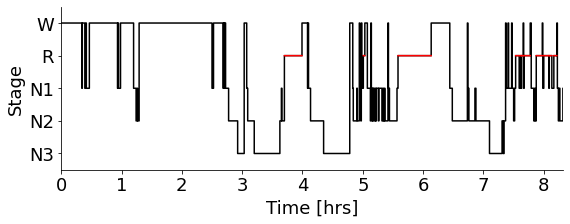

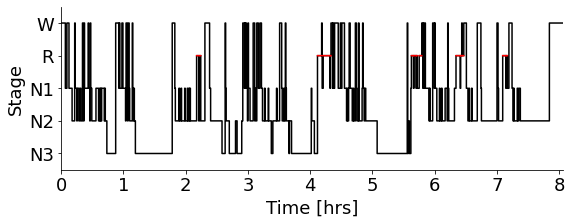

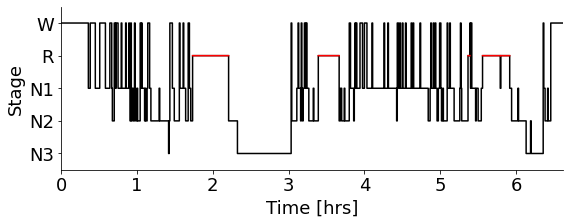

In [13]:
# Renombramos la clase 5 como clase 4 para que no de problemas las funciones. 

for i in range(hypno8.shape[0]):
    if hypno8.values[i]==5:
        hypno8.values[i]=4
        
for i in range(hypno9.shape[0]):
    if hypno9.values[i]==5:
        hypno9.values[i]=4
        
for i in range(hypno10.shape[0]):
    if hypno10.values[i]==5:
        hypno10.values[i]=4
        
        
# Los dibujamos
yasa.plot_hypnogram(hypno8)
yasa.plot_hypnogram(hypno9)
yasa.plot_hypnogram(hypno10)

In [14]:
# Recordemos que las etiquetas las teníamos en la variable `hypno`
# quitamos las últimas 30 épocas en cada caso ya que éstas no hay que tenerlas en cuenta.


# Sujeto 8
labels8 = hypno8[0:-30]
print(labels8.shape)

# Sujeto 9
labels9 = hypno9[0:-30]
print(labels9.shape)

# Sujeto 10
labels10 = hypno10[0:-30]
print(labels10.shape)

(970,)
(939,)
(766,)


In [15]:
# Nos quedamos solo con las etiquetas válidas, es decir, aquellas que no tienen ninguna anotación que pueda ser problemática.

# Sujeto 8
indices_8 = load_valid_data("./raw_data/8/8_1.xlsx",return_bool_vect=False)
labels8_validas = labels8[indices_8]

# Sujeto 9
indices_9 = load_valid_data("./raw_data/9/9_1.xlsx",return_bool_vect=False)
labels9_validas = labels9[indices_9]

# Sujeto 10
indices_10 = load_valid_data("./raw_data/10/10_1.xlsx",return_bool_vect=False)
labels10_validas = labels10[indices_10]

## Extraemos características 

En este apartado, usaremos el etiquetado automático que tiene el paquete `yasa` para predecir el polisomnograma de cada uno de los pacientes. Esto lo haremos con el fin de obtener un abanico de características que nos proporciona el mismo paquete. 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


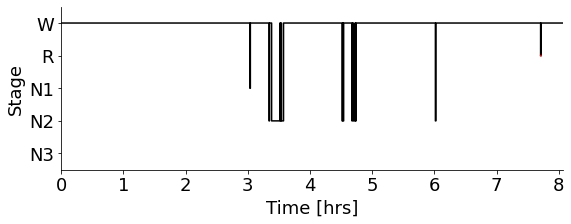

In [16]:
# Sujeto 8

# etiquetado automático en los canales de interés
sls8 = yasa.SleepStaging(raw_8, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred8 = sls8.predict()  # Predict the sleep stages
hypno_pred8 = yasa.hypno_str_to_int(hypno_pred8)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred8); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


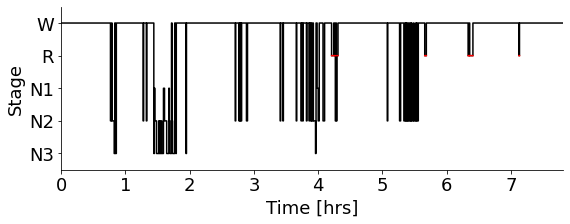

In [17]:
# Sujeto 9

# etiquetado automático en los canales de interés
sls9 = yasa.SleepStaging(raw_9, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred9 = sls9.predict()  # Predict the sleep stages
hypno_pred9 = yasa.hypno_str_to_int(hypno_pred9)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred9); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


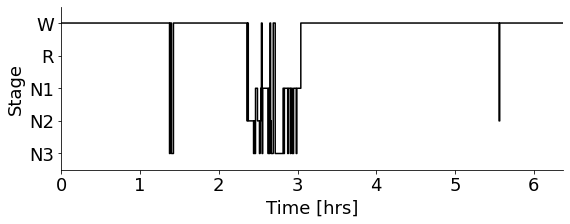

In [18]:
# Sujeto 10

# etiquetado automático en los canales de interés
sls10 = yasa.SleepStaging(raw_10, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred10 = sls10.predict()  # Predict the sleep stages
hypno_pred10 = yasa.hypno_str_to_int(hypno_pred10)  # Convert "W" to 0, "N1" to 1, "N2" to 2, "N3" to 3 and REM to "4"
yasa.plot_hypnogram(hypno_pred10); 

In [19]:
# Extraemos características

# Sujeto 8
features_8 = sls8.get_features()
# Sujeto 9
features_9 = sls9.get_features()
# Sujeto 10
features_10 = sls10.get_features()

In [20]:
# Nos quedamos solo con las características de las muestras válidas. 
# Recordemos que tenemos los índices guardados de celdas anteriores.

features_8_validas = features_8.iloc[indices_8,]

features_9_validas = features_9.iloc[indices_9,]

features_10_validas = features_10.iloc[indices_10,]

In [21]:
features_8_validas

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
1,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
4,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
5,4.136151,0.699118,0.510622,0.509817,0.535527,0.546724,7.197478,0.678086,0.721075,0.220385,...,-0.573987,-0.589859,2.007484,0.675440,0.404659,0.067857,-0.586411,-0.566482,0.041667,0.005160
6,3.458320,0.636555,0.578018,0.516499,0.549762,0.625812,5.805417,0.672804,0.812905,0.217947,...,-0.564392,-0.599877,1.839040,0.593759,0.326706,0.067775,-0.577427,-0.572207,0.050000,0.006192
7,3.780870,0.565480,0.599328,0.450488,0.554411,0.625366,4.986484,0.655540,0.820175,0.215742,...,-0.548328,-0.560838,2.218993,0.519758,0.228028,0.079574,-0.563208,-0.537433,0.058333,0.007224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,2.297324,-0.177384,-0.195025,0.159416,-0.022214,-0.029946,0.965867,-0.011093,-0.011365,0.246440,...,0.282269,0.041927,2.299645,0.165806,0.278790,0.138692,0.156989,0.009874,8.041667,0.995872
966,2.625368,-0.175691,-0.206395,0.155437,-0.022868,-0.021721,0.677207,-0.011653,-0.010807,0.253879,...,0.318626,0.142642,1.703428,0.160056,0.202415,0.171430,0.159250,-0.001860,8.050000,0.996904
967,2.702834,-0.171998,-0.173341,0.146006,-0.024636,-0.019809,0.621968,-0.012488,-0.010523,0.250021,...,0.338902,0.309921,1.816432,0.162425,0.187248,0.183805,0.166044,0.064889,8.058333,0.997936


In [22]:
# Unimos los dos dataframes de características en uno solo

X= features_8_validas.append(features_9_validas)
X.reset_index(inplace=True, drop=True)
X

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
1,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
2,4.136151,0.699118,0.510622,0.509817,0.535527,0.546724,7.197478,0.678086,0.721075,0.220385,...,-0.573987,-0.589859,2.007484,0.675440,0.404659,0.067857,-0.586411,-0.566482,0.041667,0.005160
3,3.458320,0.636555,0.578018,0.516499,0.549762,0.625812,5.805417,0.672804,0.812905,0.217947,...,-0.564392,-0.599877,1.839040,0.593759,0.326706,0.067775,-0.577427,-0.572207,0.050000,0.006192
4,3.780870,0.565480,0.599328,0.450488,0.554411,0.625366,4.986484,0.655540,0.820175,0.215742,...,-0.548328,-0.560838,2.218993,0.519758,0.228028,0.079574,-0.563208,-0.537433,0.058333,0.007224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2.748768,0.071010,0.027748,0.116109,-0.069590,-0.035383,0.631722,-0.082396,-0.082264,0.098614,...,0.235475,0.387483,1.672283,-0.056312,-0.123011,0.209698,0.273493,0.279488,7.775000,0.994669
1554,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
1555,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
1556,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868


In [23]:
# Unimos también las etiquetas 

labels_validas= labels8_validas.append(labels9_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas

0       0
1       0
2       0
3       0
4       0
       ..
1553    2
1554    2
1555    2
1556    2
1557    2
Name: 0, Length: 1558, dtype: int64

## Entrenamiento de modelos

Aquí, probaremos a entrenar un modelo con todas las características obtenidas y otro en el que solo solo tendremos en cuenta las características más importantes. El objetivo será que con menos características, consigamos un rendimiento parecido.

In [24]:
# Dividimos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X, labels_validas, test_size=0.2, random_state=0)

In [25]:
# Hacemos un Random Forest con los parámetros por defecto.

RF = OneVsRestClassifier(RandomForestClassifier(random_state=0))

RF.fit(x_train, y_train)

preds = RF.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       105
           1       0.56      0.40      0.47        25
           2       0.85      0.94      0.90        86
           3       0.93      0.98      0.95        53
           4       0.90      0.88      0.89        43

    accuracy                           0.89       312
   macro avg       0.84      0.83      0.83       312
weighted avg       0.89      0.89      0.89       312



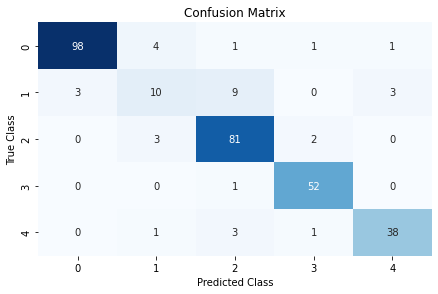

In [26]:
# Matriz de confusión 

matrix = confusion_matrix(y_test, preds)

dataframe = pd.DataFrame(matrix, index=np.sort(y_test.unique()), columns=np.sort(y_test.unique()))

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Vemos que sobre nuestro modelo está confundiendo las clases 0 (Despierto) y 3 (N3).Sin embargo, observamos que hay muchas menos muestras de la clase 3 que del resto de clases, por lo que lo ideal sería fijarnos en proporciones y no en valores absolutos.

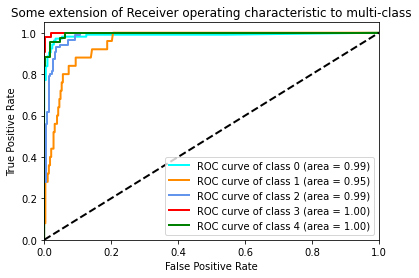

In [27]:
# Hacemos la curva ROC de cada una de las clases para el conjunto de entrenamiento

clf=RF
draw_ROC(x_test, y_test)

Las curvas ROC de cada una de las clases salen bastante bien en la fase de entrenamiento. Esto además se corresponde con un valor alto de accuracy (0.89) y valores altos de Recall y precisión para la mayoría de las clases, a excepción de la clase 1 que es la que más nos cuesta detectary y en la que más fallamos.

Vamos a intenar mejorar el modelo obtenido con una selección óptima de hiperparámetros. Esto lo haremos haciendo un barrido sobre un rango de valores que hemos considerado oportuno con la función `GridSearchCV`. Esta función nos devuelve el mejor de los módelos con el método `.best_estimator_`.

In [28]:
# Hacemos fine tuning para intentar mejorar lo obtenido con los parámetros por defecto.

RF_params={"estimator__criterion":["gini", "entropy"], "estimator__max_depth":[1,2,3,4,5,6,7,8,9,10,20,50]}

RFs=GridSearchCV(RF,RF_params)

RFs.fit(x_train,y_train)

GridSearchCV(estimator=OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0)),
             param_grid={'estimator__criterion': ['gini', 'entropy'],
                         'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  20, 50]})

In [29]:
# Nos quedamos con el mejor de los modelos probados
RF_best= RFs.best_estimator_

In [30]:
# Hacemos las predicciones con el nuevo modelo, con una elección no arbitraria de los hiperparámetros.
preds = RF_best.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       105
           1       0.56      0.40      0.47        25
           2       0.85      0.94      0.90        86
           3       0.93      0.98      0.95        53
           4       0.90      0.88      0.89        43

    accuracy                           0.89       312
   macro avg       0.84      0.83      0.83       312
weighted avg       0.89      0.89      0.89       312



In [31]:
accuracy_train_RF = accuracy_score(y_test, preds)
accuracy_train_RF

0.8942307692307693

In [32]:
auc_train_RF=roc_auc_score(y_test, RF.predict_proba(x_test),multi_class='ovr')
auc_train_RF

0.9847807517966016

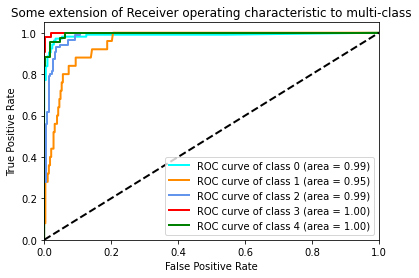

In [33]:
clf=RF_best
draw_ROC(x_test, y_test)

En general, vemos que el rendimiento del modelo no ha mejorado en absoluto. Por tanto, en adelante usaremos el modelo con los parámetros por defecto por ser más sencillo.

Además, para ver la robustez del modelo durante el entrenamiento, calculamos el área bajo la curva ROC utilizando cross-validation. 

In [34]:
# Calculamos el AUC durante el entrenamiento para ver si hay mucha variabilidad o no.
cv_results = cross_validate(RF, x_test, y_test, cv=5, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([1.2575779 , 1.1926868 , 1.10179472, 1.16144323, 1.26188779]),
 'score_time': array([0.08315563, 0.07754326, 0.0791986 , 0.05996108, 0.07695556]),
 'test_score': array([0.97013435, 0.93249927, 0.97127443, 0.97715077, 0.96396554])}

Observamos que el AUC del modelo en entrenamiento varía entre 0.93 y 0.97 que, en general, son valores altos. Consideramos que el modelo no tiene mucha variabilidad y que nos podemos fiar de predicciones puntuales sin necesidad de hacerlas repetidas veces.

## Reducción de la dimensionalidad con importancia de características

A continuación, vamos a intentar reducir el conjunto de características del que partimos inicialmente (149). Consideramos que es un número elevado de características y que podemos conseguir resultados parecidos menos características, siempre y cuando sean las más importantes para nuestro modelo.

De esta manera, calculamos las variables más importantes para cada uno de los 5 clasificadores obtenidos al hacer `OneVsRest` y nos quedamos con las que sean comunes a todos. Para determinar cuales son importantes, fijamos un umbral adecuado.

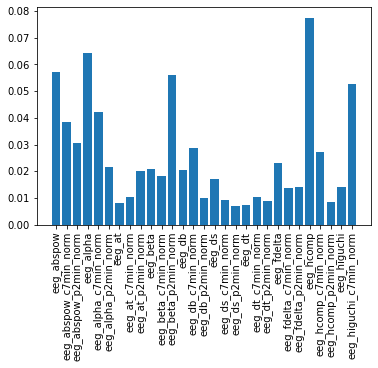

In [35]:
# Uno a uno 
# Primer clasificador 
importancias_0 = RF.estimators_[0].feature_importances_
importancias_0 = importancias_0[np.where(abs(importancias_0)>0.007)]
importancias_0_names = x_train.columns[np.where(abs(importancias_0)>0.007)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_0)),importancias_0)
plt.xticks(ticks=range(len(importancias_0)),labels=importancias_0_names,rotation=90);

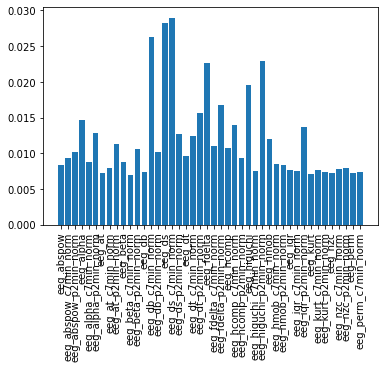

In [36]:
# Uno a uno 
# Segundo clasificador 
importancias_1 = RF.estimators_[1].feature_importances_
importancias_1 = importancias_1[np.where(abs(importancias_1)>0.007)]
importancias_1_names = x_train.columns[np.where(abs(importancias_1)>0.007)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_1)),importancias_1)
plt.xticks(ticks=range(len(importancias_1)),labels=importancias_1_names,rotation=90);

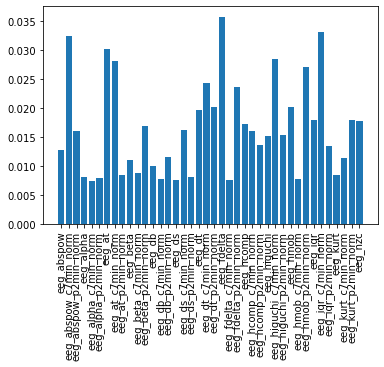

In [37]:
# Uno a uno 
# Tercer clasificador 
importancias_2 = RF.estimators_[2].feature_importances_
importancias_2 = importancias_2[np.where(abs(importancias_2)>0.007)]
importancias_2_names = x_train.columns[np.where(abs(importancias_2)>0.007)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_2)),importancias_2)
plt.xticks(ticks=range(len(importancias_2)),labels=importancias_2_names,rotation=90);

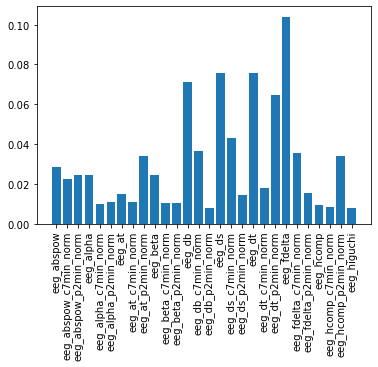

In [38]:
# Uno a uno 
# Cuarto clasificador 
importancias_3 = RF.estimators_[3].feature_importances_
importancias_3 = importancias_3[np.where(abs(importancias_3)>0.007)]
importancias_3_names = x_train.columns[np.where(abs(importancias_3)>0.007)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_3)),importancias_3)
plt.xticks(ticks=range(len(importancias_3)),labels=importancias_3_names,rotation=90);

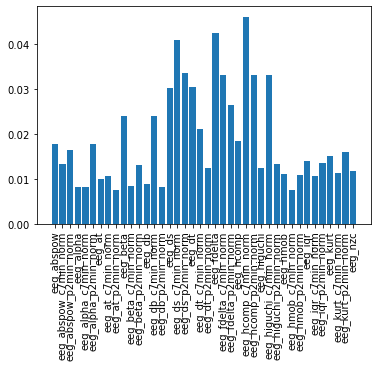

In [39]:
# Uno a uno 
# Quinto clasificador 
importancias_4 = RF.estimators_[4].feature_importances_
importancias_4 = importancias_4[np.where(abs(importancias_4)>0.007)]
importancias_4_names = x_train.columns[np.where(abs(importancias_4)>0.007)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_4)),importancias_4)
plt.xticks(ticks=range(len(importancias_4)),labels=importancias_4_names,rotation=90);

In [40]:
# Nos quedamos con las características comunes a los cinco clasificadores. 

importancias_names = importancias_0_names.append(importancias_1_names)
importancias_names.append(importancias_2_names)
importancias_names.append(importancias_3_names)
importancias_names.append(importancias_4_names) 
          
# Al usar la estructura `set`, eliminamos duplicados.
importancias_names = set(importancias_names)
importancias_names

{'eeg_abspow',
 'eeg_abspow_c7min_norm',
 'eeg_abspow_p2min_norm',
 'eeg_alpha',
 'eeg_alpha_c7min_norm',
 'eeg_alpha_p2min_norm',
 'eeg_at',
 'eeg_at_c7min_norm',
 'eeg_at_p2min_norm',
 'eeg_beta',
 'eeg_beta_c7min_norm',
 'eeg_beta_p2min_norm',
 'eeg_db',
 'eeg_db_c7min_norm',
 'eeg_db_p2min_norm',
 'eeg_ds',
 'eeg_ds_c7min_norm',
 'eeg_ds_p2min_norm',
 'eeg_dt',
 'eeg_dt_c7min_norm',
 'eeg_dt_p2min_norm',
 'eeg_fdelta',
 'eeg_fdelta_c7min_norm',
 'eeg_fdelta_p2min_norm',
 'eeg_hcomp',
 'eeg_hcomp_c7min_norm',
 'eeg_hcomp_p2min_norm',
 'eeg_higuchi',
 'eeg_higuchi_c7min_norm',
 'eeg_higuchi_p2min_norm',
 'eeg_hmob',
 'eeg_hmob_c7min_norm',
 'eeg_hmob_p2min_norm',
 'eeg_iqr',
 'eeg_iqr_c7min_norm',
 'eeg_iqr_p2min_norm',
 'eeg_kurt',
 'eeg_kurt_c7min_norm',
 'eeg_kurt_p2min_norm',
 'eeg_nzc',
 'eeg_nzc_c7min_norm',
 'eeg_nzc_p2min_norm',
 'eeg_perm',
 'eeg_perm_c7min_norm'}

Además de las características importantes, vamos a añadir algunas que consideramos que tienen sentido clínico para nuestro problema. En particular, añadimos las variables relacionadas con las ondas delta, alpha, beta y theta.

In [41]:
# Podemos probar a añadir alguna características más que pensemos que sea importante. 

importancias_names.add('eeg_theta')
importancias_names.add('eeg_fdelta')
importancias_names.add('eeg_sdelta')
importancias_names.add('eog_abspow')
importancias_names.add('eog_alpha')
importancias_names.add('eog_beta')
importancias_names.add('eog_fdelta')
importancias_names.add('eog_sdelta')
importancias_names.add('eog_theta')
importancias_names

{'eeg_abspow',
 'eeg_abspow_c7min_norm',
 'eeg_abspow_p2min_norm',
 'eeg_alpha',
 'eeg_alpha_c7min_norm',
 'eeg_alpha_p2min_norm',
 'eeg_at',
 'eeg_at_c7min_norm',
 'eeg_at_p2min_norm',
 'eeg_beta',
 'eeg_beta_c7min_norm',
 'eeg_beta_p2min_norm',
 'eeg_db',
 'eeg_db_c7min_norm',
 'eeg_db_p2min_norm',
 'eeg_ds',
 'eeg_ds_c7min_norm',
 'eeg_ds_p2min_norm',
 'eeg_dt',
 'eeg_dt_c7min_norm',
 'eeg_dt_p2min_norm',
 'eeg_fdelta',
 'eeg_fdelta_c7min_norm',
 'eeg_fdelta_p2min_norm',
 'eeg_hcomp',
 'eeg_hcomp_c7min_norm',
 'eeg_hcomp_p2min_norm',
 'eeg_higuchi',
 'eeg_higuchi_c7min_norm',
 'eeg_higuchi_p2min_norm',
 'eeg_hmob',
 'eeg_hmob_c7min_norm',
 'eeg_hmob_p2min_norm',
 'eeg_iqr',
 'eeg_iqr_c7min_norm',
 'eeg_iqr_p2min_norm',
 'eeg_kurt',
 'eeg_kurt_c7min_norm',
 'eeg_kurt_p2min_norm',
 'eeg_nzc',
 'eeg_nzc_c7min_norm',
 'eeg_nzc_p2min_norm',
 'eeg_perm',
 'eeg_perm_c7min_norm',
 'eeg_sdelta',
 'eeg_theta',
 'eog_abspow',
 'eog_alpha',
 'eog_beta',
 'eog_fdelta',
 'eog_sdelta',
 'eog_theta

In [42]:
# Total de características con el que nos quedamos.
len(importancias_names)

52

In [43]:
# Probamos a entrenar solo con dichas características que eran las más relevantes.

X2 = X[importancias_names]
X2

,eeg_hcomp,eeg_kurt_p2min_norm,eog_abspow,eeg_beta_c7min_norm,eeg_hmob_c7min_norm,eeg_ds_p2min_norm,eeg_higuchi_c7min_norm,eeg_kurt_c7min_norm,eeg_ds,eeg_kurt,...,eeg_hmob,eeg_beta,eeg_at_p2min_norm,eeg_fdelta_c7min_norm,eeg_at_c7min_norm,eog_theta,eeg_db_c7min_norm,eeg_dt,eeg_dt_c7min_norm,eeg_hmob_p2min_norm
0,1.772318,0.770837,6.383565,0.474109,0.161899,-0.075115,0.491423,0.124079,2.536228,6.114131,...,0.717763,0.261714,0.476353,-0.298011,0.645939,0.061887,-0.104132,4.039809,0.144144,-0.060128
1,1.432248,0.147879,2.913726,0.378202,0.153106,-0.109256,0.454257,0.003435,0.739180,0.081310,...,0.852622,0.271876,0.568981,-0.310698,0.675600,0.077217,-0.107320,1.048144,0.062503,0.210981
2,1.484336,-0.342520,3.635889,0.338218,0.139123,-0.130655,0.437244,-0.007812,1.376068,-0.169351,...,0.807523,0.220385,0.721075,-0.309906,0.678086,0.067857,-0.105212,1.633734,0.048358,0.286125
3,1.509726,-0.384338,3.068352,0.296026,0.120928,-0.130561,0.420226,-0.009915,1.578565,-0.323350,...,0.804543,0.217947,0.812905,-0.307780,0.672804,0.067775,-0.102283,1.209442,0.034886,0.241030
4,1.523908,-0.366377,3.526105,0.262984,0.101526,-0.125056,0.402042,0.005032,1.718055,0.076680,...,0.792401,0.215742,0.820175,-0.302747,0.655540,0.079574,-0.098638,1.698056,0.024261,0.254313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2.148248,-0.246948,2.581321,-0.210647,-0.195217,0.027112,-0.160842,0.099856,7.494780,0.362081,...,0.565463,0.098614,-0.082264,0.116513,-0.082396,0.209698,0.072099,2.856492,0.065957,-0.070277
1554,2.666046,0.016201,2.449517,-0.220940,-0.218498,0.059963,-0.171584,0.182763,12.274979,3.779976,...,0.472055,0.102038,-0.049009,0.123321,-0.095791,0.170654,0.079136,4.372815,0.073757,-0.171741
1555,3.060326,0.227719,2.311844,-0.230895,-0.239004,0.044045,-0.181470,0.226331,8.906535,3.602799,...,0.409958,0.105900,0.015782,0.129696,-0.102956,0.119026,0.085890,4.156691,0.082623,-0.212715
1556,2.685563,0.438386,2.622561,-0.240897,-0.257866,0.081103,-0.192947,0.266163,13.732394,2.651742,...,0.463542,0.087399,-0.089600,0.146062,-0.116491,0.137828,0.093263,3.942003,0.090178,-0.289513


In [44]:
# Dividimos en train y test 

x2_train, x2_test, y2_train, y2_test = train_test_split(X2, labels_validas, test_size=0.2, random_state=0)


In [45]:
# Hacemos un RandomForest con los parámetros por defecto.

RF2 = OneVsRestClassifier(RandomForestClassifier(random_state=0))

RF2.fit(x2_train, y2_train)

preds2 = RF2.predict(x2_test)

print(classification_report(y2_test, preds2))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       105
           1       0.55      0.44      0.49        25
           2       0.85      0.91      0.88        86
           3       0.91      0.98      0.95        53
           4       0.86      0.84      0.85        43

    accuracy                           0.88       312
   macro avg       0.83      0.82      0.82       312
weighted avg       0.88      0.88      0.88       312



In [46]:
# Calculamos el AUC durante el entrenamiento para ver si hay mucha variabilidad o no.
cv_results = cross_validate(RF2, x2_test, y2_test, cv=5, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([0.95910096, 1.11653614, 1.18799472, 1.07401252, 1.38022161]),
 'score_time': array([0.07728624, 0.10936761, 0.09494591, 0.10469961, 0.05981183]),
 'test_score': array([0.95422403, 0.92164309, 0.96230714, 0.97142332, 0.95058666])}

In [47]:
accuracy_train_RF2 = accuracy_score(y2_test, preds2)
accuracy_train_RF2

0.8814102564102564

In [48]:
auc_train_RF2=roc_auc_score(y2_test, RF2.predict_proba(x2_test),multi_class='ovr')
auc_train_RF2

0.9731858079109668

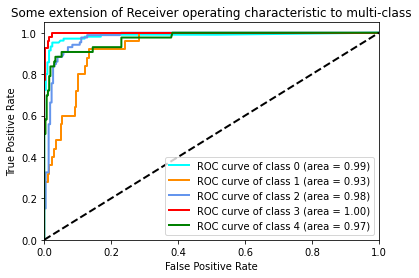

In [49]:
# Hacemos la curva ROC de cada clase para el conjunto de entrenamiento

clf=RF2
draw_ROC(x2_test,y2_test)

Observamos que, el modelo con tan solo 52 variables tiene el mismo rendimiento prácticamente que el modelo que utilizaba las 149 características iniciales. Por sencillez, el modelo con menos variables sería mejor.

## Predicción sobre el paciente 10 

Una vez tenemos los modelos entrenados, el siguiente paso es hacer la predicción sobre el paciente 10 y ver la calidad de éstas.

In [50]:
# Predicción con el modelo con todas las características
preds_10 = RF.predict(features_10_validas)
print(classification_report(labels10_validas, preds_10))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       117
           1       0.67      0.30      0.41       121
           2       0.66      0.80      0.72       122
           3       0.94      0.89      0.92       111
           4       0.98      0.74      0.84       133

    accuracy                           0.74       604
   macro avg       0.77      0.75      0.73       604
weighted avg       0.77      0.74      0.73       604



In [51]:
accuracy_test_RF = accuracy_score(labels10_validas, preds_10)

In [52]:
auc_test_RF=roc_auc_score(labels10_validas, RF.predict_proba(features_10_validas),multi_class='ovr')
auc_test_RF

0.9592627577476962

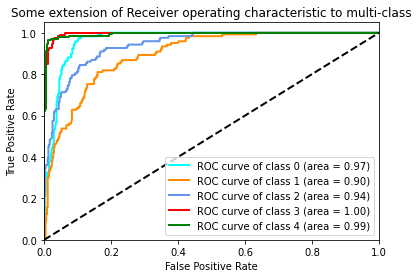

In [53]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

clf=RF
draw_ROC(features_10_validas,labels10_validas)

Observamos que el AUC sobre el conjunto de test es bastante alto en general sobre cada una de las clases. Sin embargo, viendo la tabla de métricas más arriba, vemos que hemos empeorado un poco al predecir sobre un nuevo paciente que nuestro modelo nunca ha visto. Seguimos en la misma dinámica que antes, la clase que más nos cuesta detectar es la 1 y, además, hemos empeorado en el acierto sobre las clases 0 y 2. Las clases 3 y 4 son, sin duda, sobre las que mejor lo hacemos.

In [54]:
# Predicción con el modelo con menos características
preds2_10 = RF2.predict(features_10_validas[importancias_names])
print(classification_report(labels10_validas, preds2_10))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74       117
           1       0.47      0.28      0.35       121
           2       0.56      0.75      0.64       122
           3       0.93      0.86      0.89       111
           4       0.90      0.48      0.63       133

    accuracy                           0.66       604
   macro avg       0.69      0.67      0.65       604
weighted avg       0.69      0.66      0.65       604



In [55]:
auc_test_RF2=roc_auc_score(labels10_validas, RF2.predict_proba(features_10_validas[importancias_names]),multi_class='ovr')
auc_test_RF2

0.9361725304209406

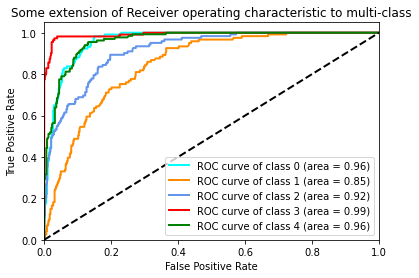

In [56]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

clf=RF2
draw_ROC(features_10_validas[importancias_names],labels10_validas)

Al usar el modelo entrenado con menos características, vemos como el acierto general baja, continuando con la dinámica de que la clase 1 sea peor. 

Echemos un vistazo a la matriz de confusión del modelo para ver en qué casos nos estamos equivocando exactamente.

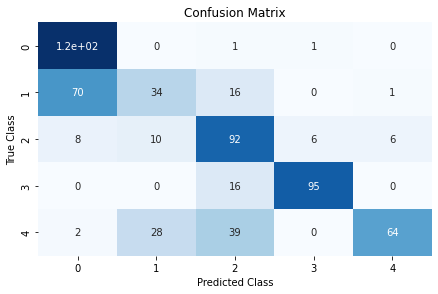

In [57]:
# Matriz de confusión  

matrix = confusion_matrix(labels10_validas, preds2_10)

dataframe = pd.DataFrame(matrix, index=labels10_validas.unique(), columns=labels10_validas.unique())

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Viendo la matriz de confusión, corroboramos la información anterior. Estamos confundiendo 63 muestras de la clase 1 y prediciendolas como la clase 0. 

Vamos a intentar ajustar los umbrales de decisión de nuestro modelo para mejorar la clasificación. Esto lo hacemos porque hay algunas clases que tienen un rango de probabilidades muy bajo, pero que si nos encontramos dentro de él debería ser suficiente para predecir dicha clase y no la que tenga una probabilidad más alta.

In [58]:
# Calculamos las probabilidades que da el modelo en cada predicción antes de asignar la clase. 

preds2_10_proba = RF2.predict_proba(features_10_validas[importancias_names])
preds2_10_proba

array([[0.40769231, 0.07692308, 0.13076923, 0.16923077, 0.21538462],
       [0.63865546, 0.23529412, 0.09243697, 0.01680672, 0.01680672],
       [0.69298246, 0.07017544, 0.0877193 , 0.03508772, 0.11403509],
       ...,
       [0.02654867, 0.14159292, 0.67256637, 0.04424779, 0.11504425],
       [0.31168831, 0.19480519, 0.18181818, 0.07792208, 0.23376623],
       [0.01219512, 0.31707317, 0.48780488, 0.02439024, 0.15853659]])

In [59]:
# Reseteamos los índices de las etiquetas para que no haya problemas al indexar
labels10_validas.reset_index(inplace=True, drop=True)
labels10_validas

0      0
1      0
2      0
3      0
4      0
      ..
599    3
600    3
601    3
602    0
603    1
Name: 0, Length: 604, dtype: int64

In [60]:
# Creamos un nuevo vector de probabilidades variando algunos umbrales para mejorar la predicción. 

preds2_10_umbrales=[]


for i in range(preds2_10_proba.shape[0]):
    if (preds2_10_proba[i][4] >= 0.2) & (preds2_10_proba[i][2] <= 0.6) :
        preds2_10_umbrales.append(4)
    elif (preds2_10_proba[i][0] < 0.55) & (preds2_10_proba[i][1] >= 0.2):
        preds2_10_umbrales.append(1)
    #if (preds2_10_proba[i][4] < 0.3) & (preds2_10_proba[i][1] >= 0.2):
    #    preds2_10_umbrales.append(1)
    else:
        preds2_10_umbrales.append(preds2_10[i])


In [61]:
print(classification_report(labels10_validas, preds2_10_umbrales))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       117
           1       0.72      0.62      0.67       121
           2       0.71      0.57      0.63       122
           3       0.93      0.86      0.89       111
           4       0.71      0.90      0.80       133

    accuracy                           0.76       604
   macro avg       0.77      0.76      0.76       604
weighted avg       0.76      0.76      0.76       604



In [62]:
accuracy_test_RF2 = accuracy_score(labels10_validas, preds2_10_umbrales)
accuracy_test_RF2

0.7599337748344371

Es bastante interesante observar como al variar los umbrales, automáticamente hemos mejorado los resultados de la predicción. El accuracy ha aumentado hasta un 0.76, superando el 0.74 que obteníamos con el modelo con todas las características. Además, hemos mejorado la precisión en general de todas las clases (a excepción de la 4) y hemos conseguido aumentar la detección de muestras de la clase 1. 

En general, hemos conseguido un modelo mejor al variar los umbrales.

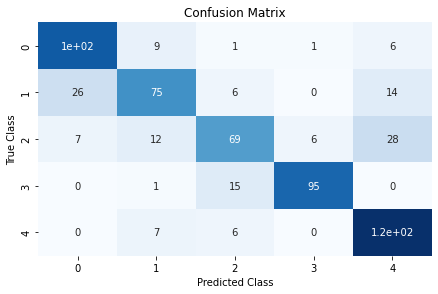

In [63]:
# Matriz de confusión  

matrix = confusion_matrix(labels10_validas, preds2_10_umbrales)

dataframe = pd.DataFrame(matrix, index=labels10_validas.unique(), columns=labels10_validas.unique())

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [64]:
# Resumen de los resultados con 3 pacientes

resumen_metricas = pd.DataFrame()
resumen_metricas['Modelo'] = ['RF', 'RF_carac_reducidas']
resumen_metricas['Accuracy_train'] = [accuracy_train_RF, accuracy_train_RF2]
resumen_metricas['AUC_train'] = [auc_train_RF, auc_train_RF2]
resumen_metricas['Accuracy_test'] = [accuracy_test_RF, accuracy_test_RF2]
resumen_metricas['AUC_test'] = [auc_test_RF, auc_test_RF2]
resumen_metricas.set_index('Modelo', inplace = True)

resumen_metricas

,Accuracy_train,AUC_train,Accuracy_test,AUC_test
Modelo,,,,
RF,0.894231,0.984781,0.741722,0.959263
RF_carac_reducidas,0.881410,0.973186,0.759934,0.936173


# Etapa final: entrenamiento con ocho y predicción con dos

Finalmente, una vez que hemos visto que es lo que funciona aproximadamente con tres pacientes, vamos a intentar extrapolarlo a los diez pacientes de los que disponemos. 

De esta manera, seguimos un preprocesado idéntico al anterior y generamos modelos parecidos pero ahora teniendo más registros para el entrenamiento. 

## Lectura y preprocesado

In [65]:
# Leemos los datos de todos los pacientes
raw_1 = mne.io.read_raw_edf('./raw_data/1/1.edf', preload=True)
raw_2 = mne.io.read_raw_edf('./raw_data/2/2.edf', preload=True)
raw_3 = mne.io.read_raw_edf('./raw_data/3/3.edf', preload=True)
raw_4 = mne.io.read_raw_edf('./raw_data/4/4.edf', preload=True)
raw_5 = mne.io.read_raw_edf('./raw_data/5/5.edf', preload=True)
raw_6 = mne.io.read_raw_edf('./raw_data/6/6.edf', preload=True)
raw_7 = mne.io.read_raw_edf('./raw_data/7/7.edf', preload=True)
raw_8 = mne.io.read_raw_edf('./raw_data/8/8.edf', preload=True)
raw_9 = mne.io.read_raw_edf('./raw_data/9/9.edf', preload=True)
raw_10 = mne.io.read_raw_edf('./raw_data/10/10.edf', preload=True)

Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\1\1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\2\2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5645999  =      0.000 ... 28229.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\3\3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4943999  =      0.000 ... 24719.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\4\4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4763999  =      0.000 ... 23819.995 secs...
Extracting EDF parameters from C:\Us

In [66]:
# Nos quedamos solo con los canales que nos interesen 

raw_1.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_2.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_3.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_4.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_5.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_6.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_7.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_8.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_9.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_10.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

<RawEDF | 10.edf, 3 x 4776000 (23880.0 s), ~109.3 MB, data loaded>

In [67]:
# Reducimos las muestras a la mitad haciendo un downsampling. Es decir, en vez de coger 200 tomas por segundo, cogeremos 100.

raw_1.resample(100)
sf1 = raw_1.info['sfreq']

raw_2.resample(100)
sf2 = raw_2.info['sfreq']

raw_3.resample(100)
sf3 = raw_3.info['sfreq']

raw_4.resample(100)
sf4 = raw_4.info['sfreq']

raw_5.resample(100)
sf5 = raw_5.info['sfreq']

raw_6.resample(100)
sf6 = raw_6.info['sfreq']

raw_7.resample(100)
sf7 = raw_7.info['sfreq']

raw_8.resample(100)
sf8 = raw_8.info['sfreq']

raw_9.resample(100)
sf9 = raw_9.info['sfreq']

raw_10.resample(100)
sf10 = raw_10.info['sfreq']

In [68]:
# Además, aplicamos un filtro de pasa-banda porque las frecuencias de interés están en un rango de 0-30 aprox

raw_1.filter(0.3, 49.99)
raw_2.filter(0.3, 49.99)
raw_3.filter(0.3, 49.99)
raw_4.filter(0.3, 49.99)
raw_5.filter(0.3, 49.99)
raw_6.filter(0.3, 49.99)
raw_7.filter(0.3, 49.99)
raw_8.filter(0.3, 49.99)
raw_9.filter(0.3, 49.99)
raw_10.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.99 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 50.00 Hz)
- Filter length: 33001 samples (330.010 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passban

<RawEDF | 10.edf, 3 x 2388000 (23880.0 s), ~54.7 MB, data loaded>

In [69]:
# Podemos acceder a los datos de la siguiente manera

data1 = raw_1.get_data() * 1e6
print(data1.shape)

data2 = raw_2.get_data() * 1e6
print(data2.shape)

data3 = raw_3.get_data() * 1e6
print(data3.shape)

data4 = raw_4.get_data() * 1e6
print(data4.shape)

data5 = raw_5.get_data() * 1e6
print(data5.shape)

data6 = raw_6.get_data() * 1e6
print(data6.shape)

data7 = raw_7.get_data() * 1e6
print(data7.shape)

data8 = raw_8.get_data() * 1e6
print(data8.shape)

data9 = raw_9.get_data() * 1e6
print(data9.shape)

data10 = raw_10.get_data() * 1e6
print(data10.shape)

(3, 2862000)
(3, 2823000)
(3, 2472000)
(3, 2382000)
(3, 2832000)
(3, 2559000)
(3, 2442000)
(3, 3000000)
(3, 2907000)
(3, 2388000)


In [70]:
# Quitamos las últimas 30 épocas, para ello, tenedremos que restar 30 épocas, de 30 segundos cada una, dónde 1 segundo son 100 
# tomas. 
# En resumen, quitamos las últimas 30*30*100 muestras.

ultimas_30 = 30*30*100


data1 = data1[:,0:-ultimas_30]

data2 = data2[:,0:-ultimas_30]

data3 = data3[:,0:-ultimas_30]

data4 = data4[:,0:-ultimas_30]

data5 = data5[:,0:-ultimas_30]

data6 = data6[:,0:-ultimas_30]

data7 = data7[:,0:-ultimas_30]

data8 = data8[:,0:-ultimas_30]

data9 = data9[:,0:-ultimas_30]

data10 = data10[:,0:-ultimas_30]


In [71]:
# Podemos echar un vistazo a las dimensiones de cada uno de los polisomnogramas
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
print(data5.shape)
print(data6.shape)
print(data7.shape)
print(data8.shape)
print(data9.shape)
print(data10.shape)

(3, 2772000)
(3, 2733000)
(3, 2382000)
(3, 2292000)
(3, 2742000)
(3, 2469000)
(3, 2352000)
(3, 2910000)
(3, 2817000)
(3, 2298000)


In [72]:
# Quitamos las últimas 30 épocas del objeto row también para que no haya problemas en las funciones espectrales que usaremos
# más adelante. 

raw_1.crop(0,data1.shape[1]/100, include_tmax = False)

raw_2.crop(0,data2.shape[1]/100, include_tmax = False)

raw_3.crop(0,data3.shape[1]/100, include_tmax = False)

raw_4.crop(0,data4.shape[1]/100, include_tmax = False)

raw_5.crop(0,data5.shape[1]/100, include_tmax = False)

raw_6.crop(0,data6.shape[1]/100, include_tmax = False)

raw_7.crop(0,data7.shape[1]/100, include_tmax = False)

raw_8.crop(0,data8.shape[1]/100, include_tmax = False)

raw_9.crop(0,data9.shape[1]/100, include_tmax = False)

raw_10.crop(0,data10.shape[1]/100, include_tmax = False)

<RawEDF | 10.edf, 3 x 2298000 (22980.0 s), ~52.6 MB, data loaded>

In [73]:
# Importamos las etiquetas de cada señal. Estas han sido puestas por dos expertos distintos que han estado en completa 
# concordancia. Se encuentran en los ficheros de texto correspondientes.

hypno1 = pd.read_csv("./raw_data/1/1_1.txt", squeeze=True, header=None)
hypno2 = pd.read_csv("./raw_data/2/2_1.txt", squeeze=True, header=None)
hypno3 = pd.read_csv("./raw_data/3/3_1.txt", squeeze=True, header=None)
hypno4 = pd.read_csv("./raw_data/4/4_1.txt", squeeze=True, header=None)
hypno5 = pd.read_csv("./raw_data/5/5_1.txt", squeeze=True, header=None)
hypno6 = pd.read_csv("./raw_data/6/6_1.txt", squeeze=True, header=None)
hypno7 = pd.read_csv("./raw_data/7/7_1.txt", squeeze=True, header=None)
hypno8 = pd.read_csv("./raw_data/8/8_1.txt", squeeze=True, header=None)
hypno9 = pd.read_csv("./raw_data/9/9_1.txt", squeeze=True, header=None)
hypno10 = pd.read_csv("./raw_data/10/10_1.txt", squeeze=True, header=None)

#Las etiquetas vienen codificadas con los números 0,1,2,3,5
print(hypno8.unique())
print(hypno9.unique())
print(hypno10.unique())

[0 1 2 3 5]
[0 1 2 3 5]
[0 1 2 3 5]


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

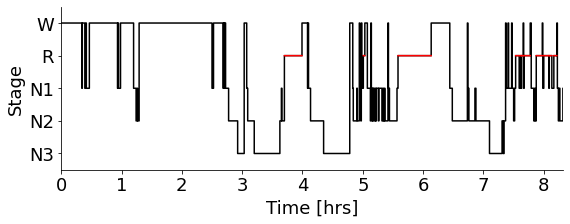

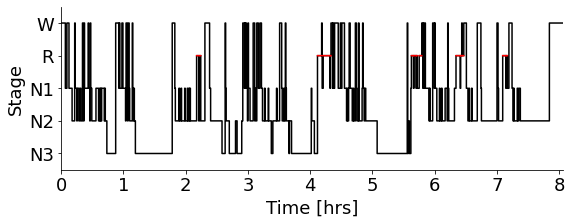

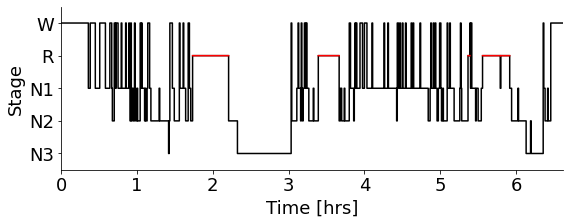

In [74]:
# Renombramos la clase 5 como clase 4 para que no de problemas las funciones. 

for i in range(hypno1.shape[0]):
    if hypno1.values[i]==5:
        hypno1.values[i]=4
        
for i in range(hypno2.shape[0]):
    if hypno2.values[i]==5:
        hypno2.values[i]=4
        
for i in range(hypno3.shape[0]):
    if hypno3.values[i]==5:
        hypno3.values[i]=4
        
for i in range(hypno4.shape[0]):
    if hypno4.values[i]==5:
        hypno4.values[i]=4
        
for i in range(hypno5.shape[0]):
    if hypno5.values[i]==5:
        hypno5.values[i]=4
        
for i in range(hypno6.shape[0]):
    if hypno6.values[i]==5:
        hypno6.values[i]=4

for i in range(hypno7.shape[0]):
    if hypno7.values[i]==5:
        hypno7.values[i]=4        

for i in range(hypno8.shape[0]):
    if hypno8.values[i]==5:
        hypno8.values[i]=4
        
for i in range(hypno9.shape[0]):
    if hypno9.values[i]==5:
        hypno9.values[i]=4
        
for i in range(hypno10.shape[0]):
    if hypno10.values[i]==5:
        hypno10.values[i]=4
        
        
# Los dibujamos
yasa.plot_hypnogram(hypno8)
yasa.plot_hypnogram(hypno9)
yasa.plot_hypnogram(hypno10)

In [75]:
# Recordemos que las etiquetas las teníamos en la variable `hypno`
# quitamos las últimas 30 épocas en cada caso ya que éstas no hay que tenerlas en cuenta.


# Sujeto 1
labels1 = hypno1[0:-30]
print(labels1.shape)

# Sujeto 2
labels2 = hypno2[0:-30]
print(labels2.shape)

# Sujeto 3
labels3 = hypno3[0:-30]
print(labels3.shape)

# Sujeto 4
labels4 = hypno4[0:-30]
print(labels4.shape)

# Sujeto 5
labels5 = hypno5[0:-30]
print(labels5.shape)

# Sujeto 6
labels6 = hypno6[0:-30]
print(labels6.shape)

# Sujeto 7
labels7 = hypno7[0:-30]
print(labels7.shape)

# Sujeto 8
labels8 = hypno8[0:-30]
print(labels8.shape)

# Sujeto 9
labels9 = hypno9[0:-30]
print(labels9.shape)

# Sujeto 10
labels10 = hypno10[0:-30]
print(labels10.shape)

(924,)
(911,)
(794,)
(764,)
(914,)
(823,)
(784,)
(970,)
(939,)
(766,)


In [76]:
# Nos quedamos solo con las etiquetas válidas, es decir, aquellas que no tienen ninguna anotación que pueda ser problemática.


# Sujeto 1
indices_1 = load_valid_data("./raw_data/1/1_1.xlsx",return_bool_vect=False)
labels1_validas = labels1[indices_1]

# Sujeto 2
indices_2 = load_valid_data("./raw_data/2/2_1.xlsx",return_bool_vect=False)
labels2_validas = labels2[indices_2]

# Sujeto 3
indices_3 = load_valid_data("./raw_data/3/3_1.xlsx",return_bool_vect=False)
labels3_validas = labels3[indices_3]


# Sujeto 4
indices_4 = load_valid_data("./raw_data/4/4_1.xlsx",return_bool_vect=False)
labels4_validas = labels4[indices_4]

# Sujeto 5
indices_5 = load_valid_data("./raw_data/5/5_1.xlsx",return_bool_vect=False)
labels5_validas = labels5[indices_5]

# Sujeto 6
indices_6 = load_valid_data("./raw_data/6/6_1.xlsx",return_bool_vect=False)
labels6_validas = labels6[indices_6]

# Sujeto 7
indices_7 = load_valid_data("./raw_data/7/7_1.xlsx",return_bool_vect=False)
labels7_validas = labels7[indices_7]

# Sujeto 8
indices_8 = load_valid_data("./raw_data/8/8_1.xlsx",return_bool_vect=False)
labels8_validas = labels8[indices_8]

# Sujeto 9
indices_9 = load_valid_data("./raw_data/9/9_1.xlsx",return_bool_vect=False)
labels9_validas = labels9[indices_9]

# Sujeto 10
indices_10 = load_valid_data("./raw_data/10/10_1.xlsx",return_bool_vect=False)
labels10_validas = labels10[indices_10]

## Extracción de características

Igual que hicimos antes en el caso de tres pacientes, extraemos las características a través de las funciones que nos brinda el paquete `yasa`. Para ello, primero tendremos que hacer el etiquetado automático y luego ya extraer las características disponibles.

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


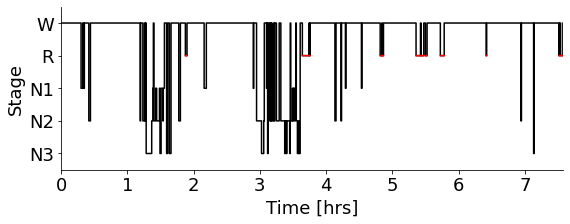

In [77]:
# Sujeto 2
sls2 = yasa.SleepStaging(raw_2, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred2 = sls2.predict()  # Predict the sleep stages
hypno_pred2 = yasa.hypno_str_to_int(hypno_pred2)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred2); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


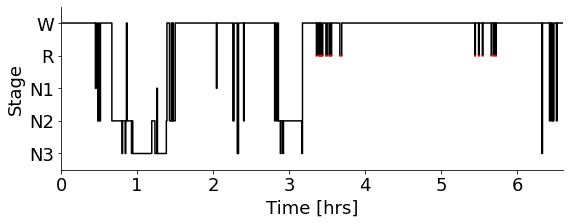

In [78]:
# Sujeto 3
sls3 = yasa.SleepStaging(raw_3, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred3 = sls3.predict()  # Predict the sleep stages
hypno_pred3 = yasa.hypno_str_to_int(hypno_pred3)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred3);

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


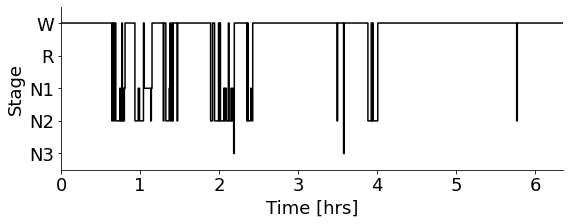

In [79]:
# Sujeto 4
sls4 = yasa.SleepStaging(raw_4, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred4 = sls4.predict()  # Predict the sleep stages
hypno_pred4 = yasa.hypno_str_to_int(hypno_pred4)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred4); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


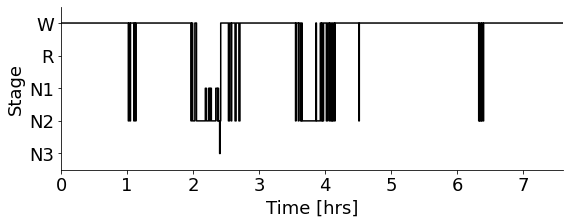

In [80]:
# Sujeto 5
sls5 = yasa.SleepStaging(raw_5, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred5 = sls5.predict()  # Predict the sleep stages
hypno_pred5 = yasa.hypno_str_to_int(hypno_pred5)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred5); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


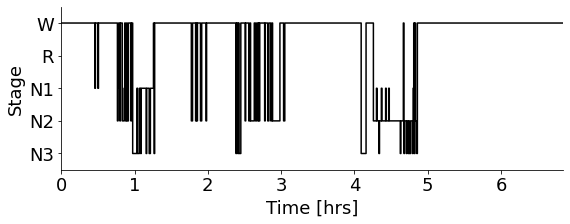

In [81]:
# Sujeto 6
sls6 = yasa.SleepStaging(raw_6, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred6 = sls6.predict()  # Predict the sleep stages
hypno_pred6 = yasa.hypno_str_to_int(hypno_pred6)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred6);

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


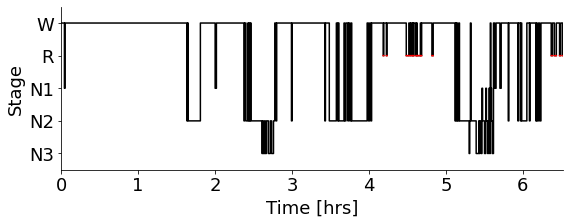

In [82]:
# Sujeto 7
sls7 = yasa.SleepStaging(raw_7, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred7 = sls7.predict()  # Predict the sleep stages
hypno_pred7 = yasa.hypno_str_to_int(hypno_pred7)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred7); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


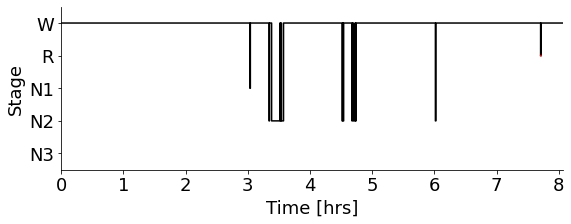

In [83]:
# Sujeto 8
sls8 = yasa.SleepStaging(raw_8, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred8 = sls8.predict()  # Predict the sleep stages
hypno_pred8 = yasa.hypno_str_to_int(hypno_pred8)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred8); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


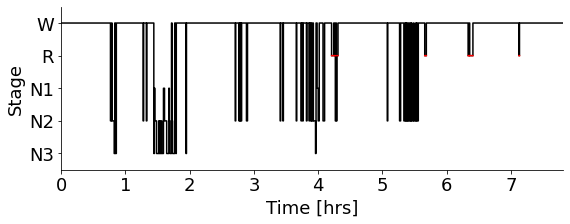

In [84]:
# Sujeto 9
sls9 = yasa.SleepStaging(raw_9, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred9 = sls9.predict()  # Predict the sleep stages
hypno_pred9 = yasa.hypno_str_to_int(hypno_pred9)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred9); 

In [85]:
# Extraemos características

# Sujeto 2
features_2 = sls2.get_features()
# Sujeto 3
features_3 = sls3.get_features()
# Sujeto 4
features_4 = sls4.get_features()
# Sujeto 5
features_5 = sls5.get_features()
# Sujeto 6
features_6 = sls6.get_features()
# Sujeto 7
features_7 = sls7.get_features()
# Sujeto 8
features_8 = sls8.get_features()
# Sujeto 9
features_9 = sls9.get_features()

In [86]:
# Nos quedamos solo con las características de las muestras válidas. 
# Recordemos que tenemos los índices guardados de celdas anteriores.

features_2_validas = features_2.iloc[indices_2,]

features_3_validas = features_9.iloc[indices_3,]

features_4_validas = features_4.iloc[indices_4,]

features_5_validas = features_9.iloc[indices_5,]

features_6_validas = features_6.iloc[indices_6,]

features_7_validas = features_9.iloc[indices_7,]

features_8_validas = features_8.iloc[indices_8,]

features_9_validas = features_9.iloc[indices_9,]

In [87]:
# Unimos todas las características en un mismo dataframe X

X= features_2_validas.append(features_3_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_4_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_5_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_6_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_7_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_8_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_9_validas)
X.reset_index(inplace=True, drop=True)
X

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,1.973582,-0.147424,-0.081585,0.165873,0.496688,0.932173,1.077612,0.738182,1.267328,0.380962,...,-0.388383,-0.332112,1.621270,-0.035563,0.296596,0.101835,-0.495903,-0.461777,0.016667,0.002198
1,1.966062,-0.148742,-0.112765,0.135891,0.388458,0.803624,0.924568,0.608527,1.066528,0.429200,...,-0.388796,-0.335191,1.588189,-0.090666,0.192883,0.095798,-0.493843,-0.455247,0.025000,0.003297
2,2.008532,-0.145865,-0.192393,0.112534,0.281028,0.577542,0.796362,0.487188,0.650950,0.453047,...,-0.389220,-0.287475,1.486755,-0.134482,-0.098210,0.100799,-0.495123,-0.414161,0.033333,0.004396
3,2.150398,-0.140506,-0.193376,0.118672,0.183586,0.391773,1.028887,0.377121,0.508159,0.453397,...,-0.391333,-0.305683,1.528943,-0.168365,-0.136632,0.074173,-0.497767,-0.461607,0.041667,0.005495
4,2.224462,-0.130641,-0.179533,0.065298,0.084941,0.143042,0.440558,0.259098,0.290970,0.404334,...,-0.386891,-0.323121,1.548022,-0.193821,-0.147180,0.077240,-0.492643,-0.521884,0.050000,0.006593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,2.748768,0.071010,0.027748,0.116109,-0.069590,-0.035383,0.631722,-0.082396,-0.082264,0.098614,...,0.235475,0.387483,1.672283,-0.056312,-0.123011,0.209698,0.273493,0.279488,7.775000,0.994669
5604,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
5605,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
5606,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868


In [88]:
# Unimos también las etiquetas 

labels_validas= labels2_validas.append(labels3_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels4_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels5_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels6_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels7_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels9_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels8_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas

0       0
1       0
2       0
3       0
4       0
       ..
5603    4
5604    4
5605    4
5606    4
5607    4
Name: 0, Length: 5608, dtype: int64

## Entrenamiento de modelos

Una vez tenemos los datos preparados, entrenamos un modelo con todas las características y otro con un número reducido de éstas. Después compararemos resultados entre ellos.

In [89]:
# Dividimos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X, labels_validas, test_size=0.2, random_state=0)

In [90]:
# Usamos los parámetros por defecto, ya que anteriormente con 3 pacientes hemos visto que no mejoraba al hacer fine tuning

RF = OneVsRestClassifier(RandomForestClassifier(random_state=0))

RF.fit(x_train, y_train)

preds = RF.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.47      0.44      0.45       262
           1       0.36      0.23      0.28        75
           2       0.57      0.64      0.60       319
           3       0.59      0.58      0.58       330
           4       0.53      0.57      0.55       136

    accuracy                           0.54      1122
   macro avg       0.50      0.49      0.49      1122
weighted avg       0.53      0.54      0.53      1122



In [91]:
kappa_RF_train=cohen_kappa_score(y_test,preds)
kappa_RF_train

0.3879634797443161

In [92]:
cv_results = cross_validate(RF, x_test, y_test, cv=5, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([4.3060286 , 4.13807893, 4.23641372, 6.43373823, 4.89539146]),
 'score_time': array([0.11222219, 0.15191412, 0.09394646, 0.11257386, 0.09492707]),
 'test_score': array([0.80115658, 0.77635189, 0.79146225, 0.72266771, 0.81038824])}

In [93]:
auc_train_RF=roc_auc_score(y_test, RF.predict_proba(x_test),multi_class='ovr')
auc_train_RF

0.7674439848813268

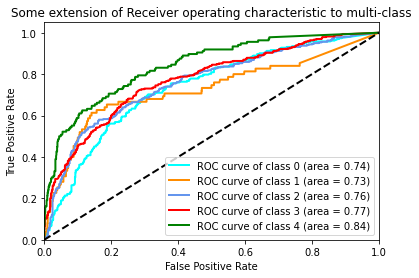

In [94]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

clf=RF
draw_ROC(x_test,y_test)

Cabe destacar que al usar 8 pacientes para entrenar, el rendimiento general del modelo baja. Empezamos a fallar en la detección de las clases y encima fallamos cuando las detectamos. 

Veamos sin al usar el conjunto de características importantes, que habíamos seleccionado anteriormente, mejora el rendimiento.

In [95]:
# Probamos ahora usando solo las características más importantes que habíamos seleccionado anteriormente y ajustando umbrales.

X2 = X[importancias_names]
X2

,eeg_hcomp,eeg_kurt_p2min_norm,eog_abspow,eeg_beta_c7min_norm,eeg_hmob_c7min_norm,eeg_ds_p2min_norm,eeg_higuchi_c7min_norm,eeg_kurt_c7min_norm,eeg_ds,eeg_kurt,...,eeg_hmob,eeg_beta,eeg_at_p2min_norm,eeg_fdelta_c7min_norm,eeg_at_c7min_norm,eog_theta,eeg_db_c7min_norm,eeg_dt,eeg_dt_c7min_norm,eeg_hmob_p2min_norm
0,1.445345,-0.320318,1.917529,0.908408,0.639778,-0.111095,0.531480,-0.592802,2.737978,-0.288564,...,0.933209,0.380962,1.267328,-0.867367,0.738182,0.101835,-0.113402,1.396852,-0.210272,0.516669
1,1.398795,-0.363392,2.048694,0.903725,0.637792,-0.114845,0.523696,-0.605095,2.085765,-0.162481,...,0.963645,0.429200,1.066528,-0.826100,0.608527,0.095798,-0.111421,1.314766,-0.199631,0.561503
2,1.374019,-0.507805,1.921100,0.887804,0.627459,-0.115850,0.513197,-0.614485,2.134066,-0.106673,...,0.983826,0.453047,0.650950,-0.773897,0.487188,0.100799,-0.108768,1.402362,-0.184159,0.649881
3,1.387002,-0.495821,1.899048,0.856697,0.608545,-0.113330,0.497727,-0.620511,3.605233,-0.134128,...,0.978266,0.453397,0.508159,-0.714535,0.377121,0.074173,-0.105432,2.092669,-0.166397,0.698175
4,1.436777,-0.487732,2.140371,0.803798,0.576398,-0.104022,0.469658,-0.617632,4.356574,-0.182805,...,0.943357,0.404334,0.290970,-0.633672,0.259098,0.077240,-0.099777,2.080599,-0.145110,0.703226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,2.148248,-0.246948,2.581321,-0.210647,-0.195217,0.027112,-0.160842,0.099856,7.494780,0.362081,...,0.565463,0.098614,-0.082264,0.116513,-0.082396,0.209698,0.072099,2.856492,0.065957,-0.070277
5604,2.666046,0.016201,2.449517,-0.220940,-0.218498,0.059963,-0.171584,0.182763,12.274979,3.779976,...,0.472055,0.102038,-0.049009,0.123321,-0.095791,0.170654,0.079136,4.372815,0.073757,-0.171741
5605,3.060326,0.227719,2.311844,-0.230895,-0.239004,0.044045,-0.181470,0.226331,8.906535,3.602799,...,0.409958,0.105900,0.015782,0.129696,-0.102956,0.119026,0.085890,4.156691,0.082623,-0.212715
5606,2.685563,0.438386,2.622561,-0.240897,-0.257866,0.081103,-0.192947,0.266163,13.732394,2.651742,...,0.463542,0.087399,-0.089600,0.146062,-0.116491,0.137828,0.093263,3.942003,0.090178,-0.289513


In [96]:
# Dividimos en train y test 

x2_train, x2_test, y2_train, y2_test = train_test_split(X2, labels_validas, test_size=0.2, random_state=0)

In [97]:
# Entrenamos un Random Forest con los parámetros por defecto y usando la estrategía OneVsRest

RF2 = OneVsRestClassifier(RandomForestClassifier(random_state=0))

RF2.fit(x2_train, y2_train)

preds2 = RF2.predict(x2_test)

print(classification_report(y2_test, preds2))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45       262
           1       0.38      0.27      0.31        75
           2       0.52      0.61      0.56       319
           3       0.55      0.54      0.55       330
           4       0.51      0.51      0.51       136

    accuracy                           0.51      1122
   macro avg       0.49      0.47      0.48      1122
weighted avg       0.51      0.51      0.51      1122



Los resultados son muy parecidos a cuando usamos todas las características. Veamos si podemos mejorarlo haciendo una selección óptima de los hiperparámetros.

In [98]:
# Hacemos fine tuning 

RF2_params={"estimator__criterion":["gini", "entropy"], "estimator__max_depth":[1,2,3,4,5,6,7,8,9,10,20,50]}

RFs=GridSearchCV(RF2,RF2_params)

RFs.fit(x2_train,y2_train)

GridSearchCV(estimator=OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0)),
             param_grid={'estimator__criterion': ['gini', 'entropy'],
                         'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  20, 50]})

In [99]:
RF2_best= RFs.best_estimator_

In [100]:
RF2_best.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 7,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 0,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(max_depth=7, random_state=0),
 'n_jobs': None}

In [101]:
preds = RF2_best.predict(x2_test)

print(classification_report(y2_test, preds))

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       262
           1       0.52      0.20      0.29        75
           2       0.45      0.66      0.54       319
           3       0.61      0.53      0.57       330
           4       0.55      0.49      0.52       136

    accuracy                           0.52      1122
   macro avg       0.53      0.46      0.48      1122
weighted avg       0.53      0.52      0.51      1122



In [102]:
cv_results = cross_validate(RF2_best, x2_test, y2_test, cv=5, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([2.3498497 , 2.59928584, 3.10366845, 2.61860347, 2.01676774]),
 'score_time': array([0.12498832, 0.16846585, 0.1160326 , 0.11568618, 0.0848465 ]),
 'test_score': array([0.77168874, 0.77051153, 0.772419  , 0.70663269, 0.77219995])}

In [103]:
auc_train_RF2=roc_auc_score(y2_test, RF2_best.predict_proba(x2_test),multi_class='ovr')
auc_train_RF2

0.799261057140048

In [104]:
kappa_RF2_train=cohen_kappa_score(y2_test,preds)
kappa_RF2_train

0.35521976355503904

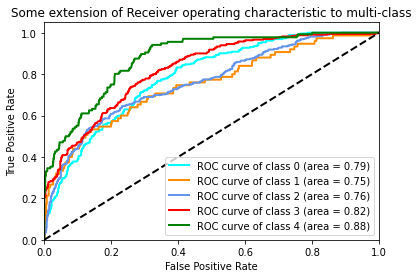

In [105]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

clf=RF2_best
draw_ROC(x2_test,y2_test)

Al hacer el tuning de hiperparámetros, conseguimos mejorar el modelo muy poco. Los resultados son poco esperanzadores en este punto, pero puede que variando los umbrales de decisión consigamos mejorar. 

Para ello, primero vamos a echar un vistazo a la matriz de confusión para ver en qué casos fallamos.

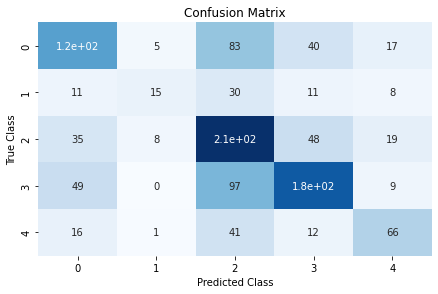

In [106]:
# Matriz de confusión  

matrix = confusion_matrix(y2_test, preds)

dataframe = pd.DataFrame(matrix, index=np.sort(y2_test.unique()), columns=np.sort(y2_test.unique()))

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Observamos como fallamos mucho al predecir las clases 0 y 3. En particular, las confundimos en repetidas ocasiones con la clase 2. También vemos otro tipo de fallos que sería conveniente intentar corregir. Para ello, vamos a intentar variar los umbrales de decisión como ya hemos comentado.

A continuación, mostramos un boxplot con el rango de valores que toman las probabilidades de cada una de las clases y que nos sirven para establecer umbrales de decisión.

In [107]:
y_probs = RF2_best.predict_proba(x2_test)
y_aux=y2_test.to_numpy()
probs_truevalues=[j[y_aux[i]] for i,j in enumerate(y_probs)]
probs_truevalues=np.array(probs_truevalues)

In [108]:
#vamos a ver que rangos de probs se gastan en cada uno de los estados
aux=[]
for i in range(5):
    valores=probs_truevalues[y_test==i]
    aux.append(valores)
#aux=np.array(aux)

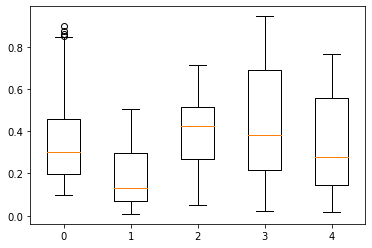

In [109]:
fig, ax = plt.subplots()
ax.boxplot(aux)
ax.set_xticklabels(range(5));

Aquí podemos ver como hay muchos umbrales que están prácticamente parejos y que por tanto nuestro modelo puede tener duda a la hora de predecir. Sin embargo, podemos hacer varias observaciones:

* La media de valores de la clase 1 toma probabilidades por debajo de 0.2.

* La clase 0 tiene un gran cantidad de outliers que toman valores por encima de 0.8 y que se comportan de manera diferente al resto.

* La mediana de las clases 0 y 4 es prácticamente la misma. Esto puede llevar a nuestro modelo a confundirse. Lo mismo ocurre con las clases 2 y 3 (esto ya lo habíamos visto en la matriz de confusión)

En base a estas observaciones, se podrían tomar las decisiones pertinentes para intentar mejorar la predicción en entrenamiento, pero no se ha hecho al final por la dificultad que presentaba.

## Predicción sobre los dos pacientes de test (1 y 10)

Cargamos los datos de los pacientes y los preprocesamos de la misma forma que hicimos durante el entrenamiento.

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


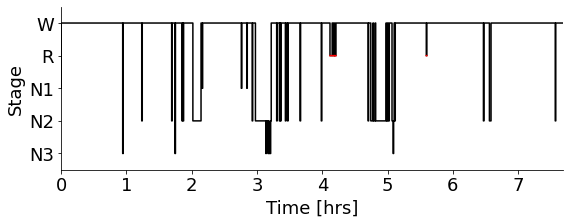

In [118]:
# Sujeto 1

# Etiquetado automático 
sls1 = yasa.SleepStaging(raw_1, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred1 = sls1.predict()  # Predict the sleep stages
hypno_pred1 = yasa.hypno_str_to_int(hypno_pred1)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred1); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


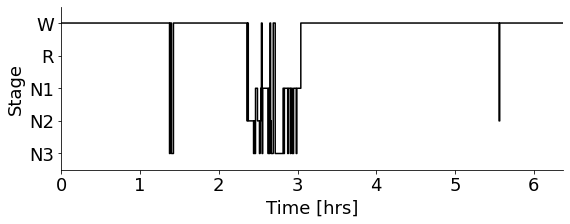

In [119]:
# Sujeto 10

# Etiquetado automático
sls10 = yasa.SleepStaging(raw_10, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred10 = sls10.predict()  # Predict the sleep stages
hypno_pred10 = yasa.hypno_str_to_int(hypno_pred10)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred10); 

In [120]:
# Extraemos características

# Sujeto 1
features_1 = sls1.get_features()
# Sujeto 10
features_10 = sls10.get_features()

In [121]:
# Nos quedamos solo con las características de las muestras válidas. 
# Recordemos que tenemos los índices guardados de celdas anteriores.


features_1_validas = features_1.iloc[indices_1,]

features_10_validas = features_10.iloc[indices_10,]

In [122]:
# Juntamos la características en un mismo dataframe X_test
X_test= features_1_validas.append(features_10_validas)
X_test.reset_index(inplace=True, drop=True)
X_test

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,2.422109,0.233205,-0.068114,0.173345,0.238790,0.280229,1.501698,0.629380,0.626704,0.264667,...,-0.759243,-0.762597,3.024283,1.849650,2.089136,0.107451,-0.802328,-0.676390,0.008333,0.001083
1,9.746064,0.229446,0.327837,0.094564,0.243265,0.128673,0.615949,0.655711,0.371362,0.231241,...,-0.741561,-0.686100,3.621311,1.626772,2.179200,0.063783,-0.806908,-0.716151,0.016667,0.002167
2,6.909308,0.180417,0.404067,0.157397,0.260895,0.144885,1.543175,0.707321,0.428067,0.221050,...,-0.731810,-0.734810,3.092365,1.364003,2.059402,0.068146,-0.808002,-0.725563,0.025000,0.003250
3,3.857998,0.114113,0.430973,0.179780,0.275714,0.157649,1.836605,0.751886,0.463907,0.344656,...,-0.713853,-0.634061,2.769561,1.086741,1.743030,0.050211,-0.809127,-0.713000,0.033333,0.004334
4,2.153688,0.050483,0.419453,0.200503,0.279996,0.197410,1.704328,0.774895,0.504199,0.393038,...,-0.700157,-0.674326,1.852548,0.799722,1.377895,0.080546,-0.804336,-0.777549,0.041667,0.005417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,3.053215,0.066581,0.097841,0.072535,-0.049731,-0.199928,0.385351,-0.200853,-0.315403,0.126466,...,0.018592,0.101860,1.766780,-0.140981,-0.121910,0.146349,0.057283,0.080696,6.341667,0.994771
1379,2.482597,0.051826,0.085134,0.138858,-0.016853,-0.093207,0.649206,-0.146305,-0.316684,0.196938,...,0.011407,0.092659,1.673120,-0.125211,-0.126135,0.173057,0.048132,0.141204,6.350000,0.996078
1380,2.658596,0.042553,0.085940,0.122178,0.002362,-0.088610,0.666410,-0.093107,-0.314954,0.183065,...,-0.010127,0.139837,1.724046,-0.102876,-0.116553,0.156046,0.026538,0.137501,6.358333,0.997386
1381,2.559589,0.039137,0.037650,0.123232,0.013468,0.031801,1.040882,-0.033961,0.004895,0.224517,...,-0.055322,-0.033972,2.642572,-0.068380,0.042847,0.076593,-0.006654,-0.039094,6.366667,0.998693


In [123]:
# Unimos también las etiquetas
labels_validas_test= labels1_validas.append(labels10_validas)
labels_validas_test.reset_index(inplace=True, drop=True)
labels_validas_test

0       0
1       0
2       0
3       0
4       0
       ..
1378    3
1379    3
1380    3
1381    0
1382    1
Name: 0, Length: 1383, dtype: int64

Una vez tenemos el conjunto de características y las etiquetas reales, procedemos a predecir usando los modelos entrenados previamente. 

In [124]:
# Modelo con todas las características
preds_RF = RF.predict(X_test)

print(classification_report(labels_validas_test, preds_RF))

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       277
           1       0.62      0.13      0.22       189
           2       0.63      0.89      0.74       402
           3       0.87      0.81      0.84       286
           4       0.91      0.60      0.72       229

    accuracy                           0.72      1383
   macro avg       0.74      0.66      0.66      1383
weighted avg       0.73      0.72      0.69      1383



Sorprende ver que los resultados en test son mejores que en entrenamiento. No terminamos de ver el por qué, quizá simplemente es que hemos tenido suerte y las muestras de test estaban muy claras para el modelo. 

Aún así, calculamos la Kappa de Cohen, que es una métrica que nos da el acierto descontando los aciertos por azar. 

In [125]:
kappa_RF_test=cohen_kappa_score(labels_validas_test,preds_RF)

Seguimos obteniendo un resultado mejor que en entrenamiento.

In [126]:
auc_test_RF=roc_auc_score(labels_validas_test, RF.predict_proba(X_test),multi_class='ovr')
auc_test_RF

0.9141724234462233

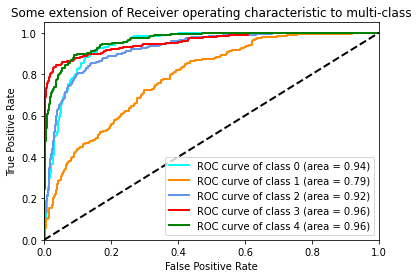

In [127]:
# Curva ROC

clf=RF
draw_ROC(X_test,labels_validas_test)

Las curvas ROC obtenidas son bastante buenas, a excepción de la de la clase 1 como ya veníamos acostumbrando.

In [128]:
# Modelo con las características más importantes

X_test_reducido = X_test[importancias_names]

preds_RF2 = RF2_best.predict(X_test_reducido)

print(classification_report(labels_validas_test, preds_RF2))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       277
           1       0.53      0.04      0.08       189
           2       0.55      0.93      0.69       402
           3       0.93      0.76      0.84       286
           4       0.71      0.39      0.51       229

    accuracy                           0.67      1383
   macro avg       0.69      0.59      0.58      1383
weighted avg       0.68      0.67      0.62      1383



In [129]:
kappa_RF2_test=cohen_kappa_score(labels_validas_test,preds_RF2)

In [130]:
auc_test_RF2=roc_auc_score(labels_validas_test, RF2_best.predict_proba(X_test[importancias_names]),multi_class='ovr')
auc_test_RF2

0.9005219484659671

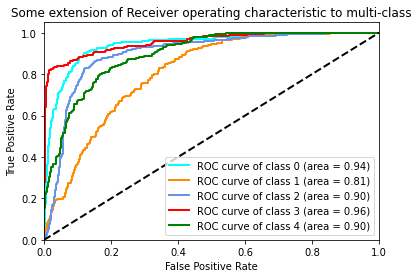

In [131]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

clf=RF2_best
draw_ROC(X_test_reducido,labels_validas_test)

El modelo entrenado con un menor número de características se queda un poco por detrás en el rendimiento general si lo comparamos con el que usa todas las características. 

Como podemos comprobar, sorprendentemente los resultados en test mejoran a los de entrenamiento. Esto se puede deber a que tengamos algún error durante el código, o simplemente a que los datos que utilizamos de test están más claros para el modelo y, por tanto, es capaz de predecirlos mejor.  

Cabe destacar también, que todos los problemas que veníamos detectando se acentúan en test. Por ejemplo, la detección de la clase 1 en test (con ambos modelos) es bastante mala.

A modo de resumen de toda esta primera parte, mostramos una tabla con los rendimientos con los modelos finales:

In [132]:
resumen_metricas = pd.DataFrame()
resumen_metricas['Modelo'] = ['RF', 'RF_carac_reducidas']
resumen_metricas['Kappa_kohen_train'] = [kappa_RF_train, kappa_RF2_train]
resumen_metricas['AUC_train'] = [auc_train_RF, auc_train_RF2]
resumen_metricas['Kappa_kohen_test'] = [kappa_RF_test, kappa_RF2_test]
resumen_metricas['AUC_test'] = [auc_test_RF, auc_test_RF2]
resumen_metricas.set_index('Modelo', inplace = True)

In [133]:
resumen_metricas

,Kappa_kohen_train,AUC_train,Kappa_kohen_test,AUC_test
Modelo,,,,
RF,0.387963,0.767444,0.634378,0.914172
RF_carac_reducidas,0.355220,0.799261,0.558272,0.900522


# Aproximación al problema alternativa (a rellenar por Arturo)